In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

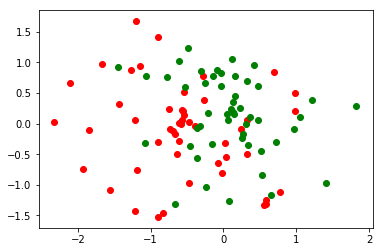

In [3]:

random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x,y = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append((x+s*math.cos(theta), y+s*math.sin(theta)))
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,(x,y),r))
    return clusters

n = 50
X = rand_clusters(2,50,1.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n, [0]*n + [1]*n]))
# label = np.array([1]*n + [0]*n)
# print (data, label)

plt.scatter(data[:n,0], data[:n,1], color=['red'])
plt.scatter(data[n:,0], data[n:,1], color=['green'])
plt.show()


In [4]:
tf.reset_default_graph()

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.get_variable(name=name, initializer=initial)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 2])
y_ = tf.placeholder(tf.float32, [None, 2])

#hidden layer
# W_fc1 = weight_variable([2, 4], 'W1')
# b_fc1 = bias_variable([4], 'b1')
# h_fc1 = tf.sigmoid(tf.matmul(x, W_fc1) + b_fc1)
# #output layer
# W_fc2 = weight_variable([4, 2], 'W2')
# b_fc2 = bias_variable([2], 'b2')
# y = tf.sigmoid(tf.matmul(h_fc1, W_fc2) + b_fc2)

n_input = 2
n_hidden = 4
n_hidden2 = 5
n_output = 2
lmd = 1e-4
# parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
                            # tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output])],0))
parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden]), tf.zeros([n_hidden]),\
#                                     tf.truncated_normal([n_hidden * n_hidden2]), tf.zeros([n_hidden2]),\
                                    tf.truncated_normal([n_hidden * n_output]), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.sigmoid(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.sigmoid(tf.matmul(hidden, weights2) + biases2)

# idx_from = idx_from + n_hidden
# weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_hidden2]), [n_hidden, n_hidden2])
# idx_from = idx_from + n_hidden*n_hidden2
# biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden2]), [n_hidden2])
# hidden2 = tf.sigmoid(tf.matmul(hidden, weights2) + biases2)

# idx_from = idx_from + n_hidden2
# weights3 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden2*n_output]), [n_hidden2, n_output])
# idx_from = idx_from + n_hidden2*n_output
# biases3 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
# y = tf.nn.sigmoid(tf.matmul(hidden2, weights3) + biases3)

weights = tf.concat([tf.reshape(weights1, [-1]), tf.reshape(weights2, [-1])], 0)
regularizer = tf.nn.l2_loss(weights)

los = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)
loss = los + lmd * regularizer

optimizer = tf.train.AdamOptimizer(1e-0)
grads_and_vars = optimizer.compute_gradients(loss)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)



In [5]:

def get_accuracy():
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return sess.run(accuracy, feed_dict={x: data, y_: label})

def get_norm_grad():
    nng = 0.
    for gv in grads_and_vars:
        # print(str(sess.run(gv[0], feed_dict={x: data, y_: label})) + " - " + gv[1].name)
        grad = sess.run(gv[0], feed_dict={x: data, y_: label})
        nng += np.linalg.norm(grad[0]) ** 2
    return np.sqrt(nng)

def display(w):

    idx_from = 0 
    weights1 = np.reshape(w[idx_from: n_input*n_hidden], [n_input, n_hidden])
    idx_from = idx_from + n_input*n_hidden
    biases1 = np.reshape(w[idx_from: idx_from+n_hidden], [n_hidden])
    idx_from = idx_from + n_hidden
    weights2 = np.reshape(w[idx_from: idx_from+n_hidden*n_output], [n_hidden, n_output])
    idx_from = idx_from + n_hidden*n_output
    biases2 = np.reshape(w[idx_from: idx_from+n_output], [n_output])
    print (weights1)
    print (biases1)
    print (weights2)
    print (biases2)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()


In [5]:
sess = tf.InteractiveSession()

dic = {}
for _ in range(100):

    tf.global_variables_initializer().run()
    flag = 0
    for i in range(1000):
        sess.run(train_step, feed_dict={x: data, y_: label})
        nng = get_norm_grad()
        if nng < 1e-8:
            flag = 1
            break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
#         display(w)
#         displayH(H)
        dic[int(v * 1e5)] = dic.get(int(v * 1e5), []) + [(min(eigs), w)]
sess.close() 

Epoch 239, accuracy 76.00%, loss 0.320315, nng 9.604e-09, nnw 14.59, high_eig 0.1045, low_eig 7.254e-14.
Epoch 169, accuracy 76.00%, loss 0.351368, nng 8.277e-09, nnw 8.203, high_eig 0.09372, low_eig -9.204e-13.
Epoch 190, accuracy 76.00%, loss 0.342640, nng 3.776e-09, nnw 7.778, high_eig 0.156, low_eig 3.987e-12.
Epoch 207, accuracy 77.00%, loss 0.320345, nng 7.135e-09, nnw 14.63, high_eig 0.1054, low_eig -4.172e-09.
Epoch 192, accuracy 75.00%, loss 0.346984, nng 4.143e-09, nnw 8.537, high_eig 0.08386, low_eig -4.931e-12.
Epoch 168, accuracy 78.00%, loss 0.336357, nng 6.228e-09, nnw 7.768, high_eig 0.08369, low_eig -1.204e-08.
Epoch 213, accuracy 78.00%, loss 0.340902, nng 9.313e-10, nnw 5.781, high_eig 0.08985, low_eig -3.004e-10.
Epoch 155, accuracy 75.00%, loss 0.330497, nng 5.466e-09, nnw 12.43, high_eig 0.09789, low_eig -1.428e-06.
Epoch 265, accuracy 78.00%, loss 0.340901, nng 3.9e-09, nnw 5.781, high_eig 0.08985, low_eig -6.05e-15.
Epoch 202, accuracy 76.00%, loss 0.351373, nng

In [6]:
for key in sorted(dic):
    print ("%s:" % (key))
    for e, v in dic[key]:
        print (e)
        display(v)

33025:
-1.29028e-09
[[  2.00981041e-04  -1.16835375e+01  -1.98152359e-03  -4.53153992e+00]
 [ -4.73890221e-03   3.50707793e+00   2.83185486e-03  -6.81287527e+00]]
[-10.46237755  -5.12524939  -7.76072836  -0.88010037]
[[  1.34084508e-01  -2.05596127e-02]
 [  2.15846109e+00  -2.15289426e+00]
 [ -1.13073774e-01  -4.63075907e-04]
 [  2.51508069e+00  -2.50468469e+00]]
[-2.17556763  2.16860509]
33026:
-1.55254e-09
[[ -2.80412380e-03  -1.16904478e+01   4.51984310e+00  -3.05295951e-04]
 [ -8.28090357e-04   3.50562286e+00   6.80034399e+00  -8.80599953e-04]]
[ -9.25848389  -5.12742472   0.87862444 -11.90273952]
[[-0.31488526  0.27877745]
 [ 2.15394998 -2.15380001]
 [-2.50726295  2.50705814]
 [-0.20662026  0.06780826]]
[ 0.33813208 -0.33804536]
33633:
-7.01337e-12
[[  6.16855049e+00  -1.23263846e-04  -4.37604284e+00  -1.78496468e+00]
 [  5.55536222e+00   2.20564441e-04  -1.69206452e+00   7.79499197e+00]]
[  0.48234153  -9.76311588  -7.37112999 -12.24971104]
[[-2.79343224  2.7932663 ]
 [ 0.0396806

In [326]:
w0 = np.array([10,0,0,0,1,0,0,0, 
              0,0,0,0,
              0,0,0,0,0,0,0,0, 
              0,0])
private_init = parameters.assign(w0)

idx = [1,2,3,5,6,7,
            9,10,11] + \
            list(range(14,20))
fix_coordinate = []
for i in idx:
    fix_coordinate.append(parameters[i].assign(0))

In [327]:

sess = tf.InteractiveSession()

dic = {}
for _ in range(1):

    tf.global_variables_initializer().run()
    sess.run(private_init)    
    flag = 0
    for i in range(1000):
        sess.run(train_step, feed_dict={x: data, y_: label})
        for op in fix_coordinate:
            sess.run(op)
        nng = get_norm_grad()
        if nng < 1e-8:
            flag = 1
            break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        display(w)
#         displayH(H)
#         dic[int(v * 1e5)] = dic.get(int(v * 1e5), []) + [(min(eigs), w)]
    
    
    idx = [2,3,6,7,
            10,11] + \
            list(range(16,20))
    fix_coordinate2 = []
    for i in idx:
        fix_coordinate2.append(parameters[i].assign(0))
    flag = 0
    sess.run(parameters[1].assign(1.))
    for i in range(1000):
        sess.run(train_step, feed_dict={x: data, y_: label})
        for op in fix_coordinate2:
            sess.run(op)
        nng = get_norm_grad()
        if nng < 1e-8:
            flag = 1
            break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        display(w)
        
    idx = [3,7,
            11] + \
            list(range(18,20))
    fix_coordinate2 = []
    for i in idx:
        fix_coordinate2.append(parameters[i].assign(0))
    flag = 1
    sess.run(parameters[17].assign(.5))
    for i in range(1000):
        sess.run(train_step, feed_dict={x: data, y_: label})
        for op in fix_coordinate2:
            sess.run(op)
        nng = get_norm_grad()
        if nng < 1e-8:
            flag = 1
            break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        display(w)
         
sess.close() 

Epoch 204, accuracy 75.00%, loss 0.353688, nng 6.461e-09, nnw 6.138, high_eig 0.1378, low_eig -0.001555.
[[ 6.1384387   0.          0.          0.        ]
 [ 3.85529733  0.          0.          0.        ]]
[ 0.0328644  0.         0.         0.       ]
[[-3.14847136  3.14847159]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
[ 1.25850093 -1.25850058]
Epoch 256, accuracy 75.00%, loss 0.330258, nng 2.619e-10, nnw 12.53, high_eig 0.1263+0j, low_eig -0.001666+0j.
[[  4.52024651 -11.69125748   0.           0.        ]
 [  6.80131388   3.50514174   0.           0.        ]]
[ 0.87811577 -5.12807369  0.          0.        ]
[[-2.50723052  2.50723052]
 [ 2.15404177 -2.15404272]
 [ 0.          0.        ]
 [ 0.          0.        ]]
[ 0.3379378  -0.33793768]
Epoch 171, accuracy 75.00%, loss 0.330258, nng 5.093e-09, nnw 12.53, high_eig 0.1119, low_eig -0.001501.
[[  4.52028894e+00  -1.16912632e+01   2.49887467e-04   0.00000000e+00]
 [  6.80136728e+00   3.50522

In [21]:
w0 = np.array([0,0,0,0,0,0,0,0, 
              1e-4,0,0,0,
              0,0,0,0,0,0,0,0, 
              0,0])
# w0 = np.array([0.5]*22)
private_init = parameters.assign(w0)

sess = tf.InteractiveSession()

dic = {}
for _ in range(1):

    tf.global_variables_initializer().run()
    sess.run(private_init)    
    flag = 1
    for i in range(1000):
#         idx = random.randint(0, 9)
#         sess.run(train_step, feed_dict={x: data[idx*10: (idx+1)*10], y_: label[idx*10: (idx+1)*10]})
        sess.run(train_step, feed_dict={x: data, y_: label})
        
        if i % 20 == 0:
            v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
            nng = get_norm_grad()
            eigs = sorted(np.linalg.eigvals(H)[0])
            print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
#             display(w)
            if nng < 1e-8:
                flag = 1
                break

    if flag == 1:
        v, H, w = sess.run([loss, hess, parameters], feed_dict={x: data, y_: label})    
        eigs = sorted(np.linalg.eigvals(H)[0])
        print("Epoch {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g}, nnw {:.4g}, high_eig {:.4g}, low_eig {:.4g}."\
                    .format(i+1, get_accuracy()*100, v, nng, np.linalg.norm(w[:n_hidden]), max(eigs), min(eigs) ))
        display(w)
#         displayH(H)
#         dic[int(v * 1e5)] = dic.get(int(v * 1e5), []) + [(min(eigs), w)]
    

Epoch 1, accuracy 50.00%, loss 0.500010, nng 0.0002347, nnw 0, high_eig 0.2519+0j, low_eig -0.03067+0j.
Epoch 21, accuracy 76.00%, loss 0.411710, nng 0.003837, nnw 7.449, high_eig 0.07424+0j, low_eig -0.008044+0j.
Epoch 41, accuracy 74.00%, loss 0.385667, nng 0.002368, nnw 6.098, high_eig 0.09105+0j, low_eig -0.002281+0j.
Epoch 61, accuracy 76.00%, loss 0.358243, nng 0.002596, nnw 6.689, high_eig 0.08753+0j, low_eig 2.384e-06+0j.
Epoch 81, accuracy 75.00%, loss 0.355528, nng 0.0002112, nnw 6.816, high_eig 0.112, low_eig 2.84e-07.
Epoch 101, accuracy 75.00%, loss 0.354500, nng 0.0006012, nnw 6.072, high_eig 0.1066, low_eig -3.075e-07.
Epoch 121, accuracy 75.00%, loss 0.354023, nng 8.551e-05, nnw 6.075, high_eig 0.1095, low_eig 2.073e-08.
Epoch 141, accuracy 75.00%, loss 0.353827, nng 9.836e-05, nnw 6.169, high_eig 0.1093+0j, low_eig 2.355e-09+0j.
Epoch 161, accuracy 75.00%, loss 0.353739, nng 2.179e-05, nnw 6.133, high_eig 0.1092+0j, low_eig 4.086e-10+0j.
Epoch 181, accuracy 75.00%, los